## Objectif
- Automatiser l'étiquettage des données
- Filtrer pour ne garder que les entrées qui nous intéresse

In [16]:
import pandas as pd
import numpy as np
import seaborn as sn
from datetime import datetime
import re

from utils import get_full_df

In [17]:
df = get_full_df()

In [18]:
port_classes = ['NLRTM','FRBES','FRLEH',
                  'FRSML','ESSDR','FRMTX',
                  'FRBOD','BEANR','FRIRK',
                  'ESBIO']

In [19]:
port_regexp = {
    "NLRTM": re.compile("nl\s*rtm|rotter"),
    "FRBES": re.compile("brest|bes"),
    "FRLEH": re.compile("leh|havre"),
    "FRSML": re.compile("malo|sml"),
    "ESSDR": re.compile("santand|es\s*sdr"),
    "FRMTX": re.compile("montoir|mtx"),
    "FRBOD": re.compile("bod|bordeau"),
    "BEANR": re.compile("anr|antwerp"),
    "FRIRK": re.compile("irk|dunker"),
    "ESBIO": re.compile("bilbao|es\s*bio")    
}

In [20]:
def find_match(destination, regexp_dict):
    """Find a match in the destination
    
    Parameters:
        destination (str): raw input destination

    Returns:
        str: Predicted label (port)
    """
    
    for code, pattern in regexp_dict.items():
        if(pattern.search(destination.lower())): return code
    return ""

In [21]:
def damerau_levenshtein_distance(s1, s2):
    """Compute the Damerau-Levenshtein distance between two given
    strings (s1 and s2)
    
    Parameters:
        s1 (str): first string
        s2 (str): second string
    
    Returns:
        int: Return the damerau levenshtein distance (number of changes)
    """
    
    d = {}
    lenstr1 = len(s1)
    lenstr2 = len(s2)
    for i in range(-1,lenstr1+1):
        d[(i,-1)] = i+1
    for j in range(-1,lenstr2+1):
        d[(-1,j)] = j+1

    for i in range(lenstr1):
        for j in range(lenstr2):
            if s1[i] == s2[j]:
                cost = 0
            else:
                cost = 1
            d[(i,j)] = min(
                           d[(i-1,j)] + 1, # deletion
                           d[(i,j-1)] + 1, # insertion
                           d[(i-1,j-1)] + cost, # substitution
                          )
            if i and j and s1[i]==s2[j-1] and s1[i-1] == s2[j]:
                # transposition
                d[(i,j)] = min (d[(i,j)], d[i-2,j-2] + cost)

    return d[lenstr1-1,lenstr2-1]

In [22]:
def generate_label(x):
    """Return the closes class with Damerau distance
    
    Parameters:
        x (pandas.core.series.Series): a row of the dataframe
    
    Returns:
        str: Predicted label (port)
    """
    
    raw_input = x["destination"]
    min_distance = -1
    port = None
    for port_index in world_port_idx:
        distance = damerau_levenshtein_distance(raw_input, port_index)
        if min_distance == -1: 
            min_distance = distance
            port = port_index
        elif min_distance > distance:
            min_distance = distance
            port = port_index
    
    if distance > 10: port = None
    return port

In [24]:
### Label the dataset

df["code"] = df.apply(
    lambda x: find_match(x["destination"], port_regexp),
    axis=1
)

In [25]:
no_code_rows = df[df["code"] == ""].index.tolist()

In [30]:
f"""Unlabeled rows: {len(no_code_rows)}
| Labeled rows: {len(df) - len(no_code_rows)}
| Total rows: {len(df)}"""

'Unlabeled rows: 2086\n| Labeled rows: 248\n| Total rows: 2334'

In [31]:
# remove lines with no code
dataset_ten = df.drop(no_code_rows)
dataset_ten

,destination,code
0,BREST,FRBES
2,RADE DE BREST,FRBES
114,SANTANDER,ESSDR
147,ROTTERDAM,NLRTM
254,BREST PILOT,FRBES
...,...,...
846317,MONTOIR VIA NOK,FRMTX
849088,"DUKIRK, FRANCE",FRIRK
852646,FR DON > FR LEH,FRLEH
857105,DUNKIRK/FRANCE,FRIRK


In [36]:
df.loc[no_code_rows]

,destination,code
5,SALVAGE TUG,
10,WORKING AREA,
13,LA TURBALLE,
14,ST GILLE + DE UIE,
50,DOUARNENEZ,
...,...,...
863801,PT SET >DE EME,
872623,SWANSEA,
878994,CABLE WORK NORTH SEA,
881997,ST. PETER,


[Text(0.5, 1.0, 'Distribution des classes'),
 Text(0.5, 0, 'World Port Index'),
 Text(0, 0.5, 'Datapoints')]

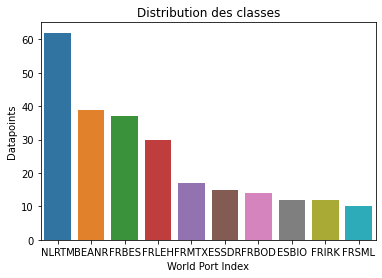

In [58]:
label_distribution = dataset_ten["code"].value_counts()
sn.barplot(
    x=label_distribution.index,
    y=label_distribution.tolist()
).set(title="Distribution des classes", xlabel="World Port Index",
      ylabel="Datapoints")

In [177]:
dataset_ten[dataset_ten["code"] == "NLRTM"]["destination"].tolist()

['ROTTERDAM',
 'BITUNG>ROTTERDAM',
 'NLRTM',
 'NL RTM',
 'ROTTERDAM<>DUBLIN',
 'CO SMR>NL RTM',
 'ROTTERDAM NL',
 'NL-ROTTERDAM',
 'ROTTERDAM FOR ORDER',
 'ROTTERDAM NED.',
 'ROTTERDAM FOR ORDERS',
 'MAPTM>>NLRTM',
 'HR RJK > NL RTM',
 'ROTTERDAM NL RTM',
 'ESVLC>NLRTM',
 'ESBIO > NLRTM',
 'ROTTERDAM,NETHERLAND',
 'ROTTERDAM FO',
 'BR TUB>NL RTM',
 'COCTG-NLRTM',
 'ROTTERDAM NETHERLAND',
 'NLRTM>EGSUZ',
 'ROTTERDAM EMO',
 'MAPTM>NLRTM',
 'PTLEI & NLRTM',
 'ROTTERDAM-NETHERLAND',
 'ROTTERDAMRYANBU',
 'IT AUG>NL RTM',
 'DZ MOS>NL RTM',
 'ESLAP > NLRTM',
 'MAPTM-NLRTM',
 'NLRTM_FRBAY',
 'FRBAY>NLRTM',
 'NL RTM>CA HAL',
 'ROTTERDOM -ETA UTC-',
 'FR BAY>NL RTM',
 'ES BCN> NL RTM',
 'NLRTM>CA PCA',
 'ROTTERDAM-NL',
 'COCTG - NLRTM',
 'ROTTERDAM / NLRTM',
 'ROTTERDAM  F.O.',
 '"MZ MPM>NL RTM"',
 'NL RTM>FR LAV',
 'NL RTM > FR NTE',
 'UANIK>NLRTM',
 'ROTTERDAM, NL',
 'ROTTERAM',
 'FR NTE > NL RTM',
 'NL RTM>FR NTE',
 'FR LPE>NL RTM',
 'NL RTM TO US PME',
 'SGSIN -> NLRTM',
 '>NL RTM',
 'NL RTM

In [85]:
def regexp_processing(destination):
    """ Removes noise from destination
    FR LPE>NL RTM should return NLRTM
    NL RTM/FR DON should return FRDON
    
    Parameters:
        destination (str):
    
    Returns:
        str: Clean destination
    """
    pattern = re.compile("[->/]+")
    matches = pattern.findall(destination)
    
    return destination.split(matches[-1])[-1].strip()

In [86]:
regexp_processing("SGSIN -> NLRTM")

'NLRTM'